<a href="https://colab.research.google.com/github/aoyilmaz/Cats-vs-Dogs/blob/main/Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs vs Cats

The Dogs vs. Cats dataset is a standard computer vision dataset that involves classifying photos as either containing a dog or cat.

Although the problem sounds simple, it was only effectively addressed in the last few years using deep learning convolutional neural networks. While the dataset is effectively solved, it can be used as the basis for learning and practicing how to develop, evaluate, and use convolutional deep learning neural networks for image classification from scratch.

In this article we'll see
* How to load, extract, explore and prepare the data
* How develop a convolutional neural network for photo classification from scratch and improve model performance
* How to develop a model for photo classification using transfer learning
* How to compare the models that we've built
* How to predict an image from anywhere

Source: [Kaggle](https://www.kaggle.com/competitions/dogs-vs-cats)

## Import necassary files

In [58]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub

## Download the data

The dogs vs cats dataset refers to a dataset used for a Kaggle machine learning competition held in 2013.

The dataset is comprised of photos of dogs and cats provided as a subset of photos from a much larger dataset of 3 million manually annotated photos.

You can access the datasets from competition page on [Kaggle](https://www.kaggle.com/competitions/dogs-vs-cats). You can find the same dataset from any other website. But there are some differences. You need to be careful. Some datasets categorized and some of them not. Because of that, you need to preprocess different way.

In kaggle competition page, the data set splitted into test and train. And not categorized.

In [3]:
# Dataset directories
test_dir = "/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_dataset/test1.zip"
train_dir = "/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_dataset/train.zip"

## Extract the data

In [4]:
# Create function to unzip a zipfile into current working directory
# (since we're going to be downloading and unzipping a few files)
def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [5]:
unzip_data(test_dir)
unzip_data(train_dir)

## Explore the data

In [6]:
# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir("/content/test1")

There are 0 directories and 12500 images in '/content/test1'.


In [8]:
walk_through_dir("/content/train")

There are 0 directories and 25000 images in '/content/train'.


In [9]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [10]:
# View an image
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (282, 366, 3)


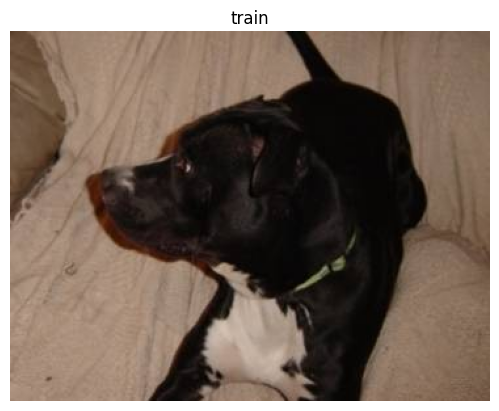

In [11]:
img = view_random_image(target_dir="/content/",
                        target_class="train")

## Preprocess the data

We will create a pandas dataframe contains image paths and labels. In the next step we will use this dataframe.

In [12]:
def preprocess_dir_to_df(dir):
    image_path = []
    label = []
    for img in os.listdir(dir):
        image_path.append(os.path.join(dir, img))
        if img.split(".")[0] == "dog":
            label.append("dog")
        else:
            label.append("cat")

    return pd.DataFrame({"image_path": image_path, "label": label})

In [13]:
df = preprocess_dir_to_df("/content/train")

In [14]:
df.head()

,image_path,label
0,/content/train/cat.10868.jpg,cat
1,/content/train/dog.3854.jpg,dog
2,/content/train/cat.1514.jpg,cat
3,/content/train/dog.11814.jpg,dog
4,/content/train/dog.8836.jpg,dog


In [15]:
df.label.value_counts()

cat    12500
dog    12500
Name: label, dtype: int64

In [16]:
# Split the data into train and validation
from sklearn.model_selection import train_test_split

train, validation = train_test_split(df, test_size=0.2, random_state=42)

## Data augmentation

Data augmentation is performed in deep learning for several reasons:
* Increasing Data Diversity
* Mitigating Overfitting
* Enhancing Generalization
* Addressing Data Scarcity

In [17]:
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

valid_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

In [18]:
# Import data from dataframe and turn it into batches
train_data = train_datagen.flow_from_dataframe(train,
                                               x_col="image_path",
                                               y_col="label",
                                               batch_size=32, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_dataframe(validation,
                                               x_col="image_path",
                                               y_col="label",
                                               batch_size=32, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Model 0: Base model

In [19]:
# Create a model
model_0 = tf.keras.Sequential([
    Conv2D(filters=10,
                          kernel_size=3,
                          strides=1,
                          padding="valid",
                          activation="relu",
                          input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [20]:
# Compile the model
model_0.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [21]:
# Summary of the model_0
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 10)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 10)       0

In [22]:
# Fit the model
history_0 = model_0.fit(train_data,
                       epochs=10,
                       steps_per_epoch=len(train_data),
                       validation_data=valid_data,
                       validation_steps=len(valid_data))

Epoch 1/10
625/625 [==============================] - 346s 532ms/step - loss: 0.6447 - accuracy: 0.6094 - val_loss: 0.6055 - val_accuracy: 0.6714
Epoch 2/10
625/625 [==============================] - 335s 536ms/step - loss: 0.5624 - accuracy: 0.7063 - val_loss: 0.5508 - val_accuracy: 0.7192
Epoch 3/10
625/625 [==============================] - 337s 539ms/step - loss: 0.5347 - accuracy: 0.7321 - val_loss: 0.5542 - val_accuracy: 0.7112
Epoch 4/10
625/625 [==============================] - 324s 518ms/step - loss: 0.5139 - accuracy: 0.7475 - val_loss: 0.5199 - val_accuracy: 0.7502
Epoch 5/10
625/625 [==============================] - 310s 496ms/step - loss: 0.4983 - accuracy: 0.7578 - val_loss: 0.5189 - val_accuracy: 0.7468
Epoch 6/10
625/625 [==============================] - 336s 537ms/step - loss: 0.4859 - accuracy: 0.7696 - val_loss: 0.5105 - val_accuracy: 0.7542
Epoch 7/10
625/625 [==============================] - 313s 502ms/step - loss: 0.4735 - accuracy: 0.7756 - val_loss: 0.4882 -

In [23]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

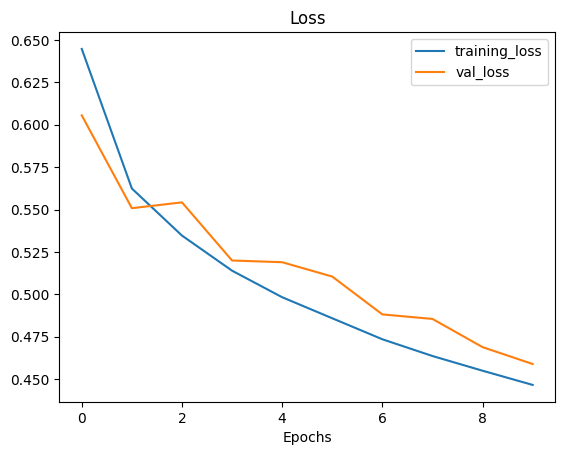

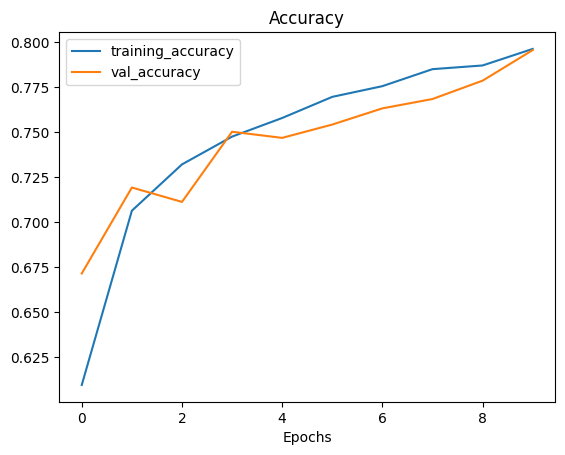

In [24]:
plot_loss_curves(history_0)

## Model 1: Adjust the model parameters

Let's change some parameters to increase our model performance.

In [25]:
# Create a model
model_1 = tf.keras.Sequential([
    Conv2D(filters=32,
                          kernel_size=3,
                          strides=1,
                          padding="valid",
                          activation="relu",
                          input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [26]:
# Compile the model
model_1.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [27]:
# Summary of the model_0
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [28]:
# Fit the model
history_1 = model_1.fit(train_data,
                       epochs=10,
                       steps_per_epoch=len(train_data),
                       validation_data=valid_data,
                       validation_steps=len(valid_data))

Epoch 1/10
625/625 [==============================] - 345s 547ms/step - loss: 0.6290 - accuracy: 0.6414 - val_loss: 0.6081 - val_accuracy: 0.6684
Epoch 2/10
625/625 [==============================] - 323s 516ms/step - loss: 0.5440 - accuracy: 0.7217 - val_loss: 0.5071 - val_accuracy: 0.7616
Epoch 3/10
625/625 [==============================] - 321s 513ms/step - loss: 0.4962 - accuracy: 0.7602 - val_loss: 0.4757 - val_accuracy: 0.7782
Epoch 4/10
625/625 [==============================] - 322s 516ms/step - loss: 0.4671 - accuracy: 0.7782 - val_loss: 0.5063 - val_accuracy: 0.7490
Epoch 5/10
625/625 [==============================] - 318s 509ms/step - loss: 0.4420 - accuracy: 0.7944 - val_loss: 0.4424 - val_accuracy: 0.8036
Epoch 6/10
625/625 [==============================] - 323s 516ms/step - loss: 0.4241 - accuracy: 0.8040 - val_loss: 0.4438 - val_accuracy: 0.7982
Epoch 7/10
625/625 [==============================] - 320s 512ms/step - loss: 0.4005 - accuracy: 0.8177 - val_loss: 0.4069 -

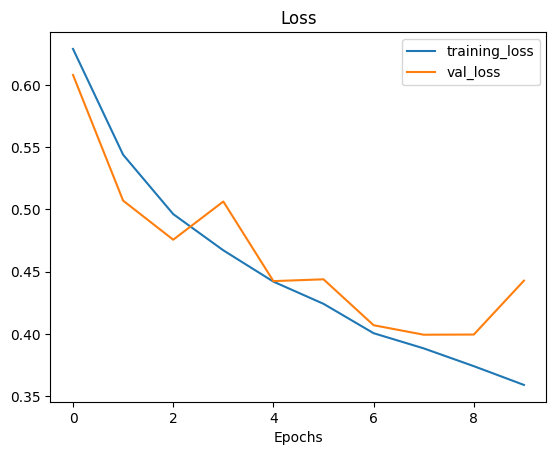

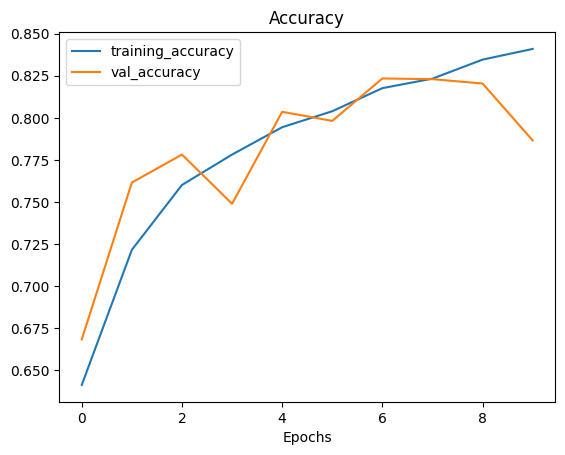

In [29]:
plot_loss_curves(history_1)

Our model is growing. Model_0 accuracy was 75%. Model_1 accuracy is 85%. Let's add some extra layers to our model and increase epoch.

## Model 2

In [30]:
# Create a model
model_2 = tf.keras.Sequential([
    Conv2D(filters=32,
                          kernel_size=3,
                          strides=1,
                          padding="valid",
                          activation="relu",
                          input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [31]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [32]:
# Fit the model
history_2 = model_2.fit(train_data,
                       epochs=20,
                       steps_per_epoch=len(train_data),
                       validation_data=valid_data,
                       validation_steps=len(valid_data))

Epoch 1/20
625/625 [==============================] - 317s 504ms/step - loss: 0.6639 - accuracy: 0.5943 - val_loss: 0.6002 - val_accuracy: 0.6748
Epoch 2/20
625/625 [==============================] - 321s 513ms/step - loss: 0.5506 - accuracy: 0.7220 - val_loss: 0.5164 - val_accuracy: 0.7460
Epoch 3/20
625/625 [==============================] - 316s 506ms/step - loss: 0.4814 - accuracy: 0.7690 - val_loss: 0.4800 - val_accuracy: 0.7802
Epoch 4/20
625/625 [==============================] - 320s 512ms/step - loss: 0.4289 - accuracy: 0.8023 - val_loss: 0.4245 - val_accuracy: 0.8130
Epoch 5/20
625/625 [==============================] - 339s 542ms/step - loss: 0.3900 - accuracy: 0.8259 - val_loss: 0.4241 - val_accuracy: 0.8068
Epoch 6/20
625/625 [==============================] - 319s 511ms/step - loss: 0.3599 - accuracy: 0.8380 - val_loss: 0.3960 - val_accuracy: 0.8186
Epoch 7/20
625/625 [==============================] - 343s 549ms/step - loss: 0.3334 - accuracy: 0.8548 - val_loss: 0.3319 -

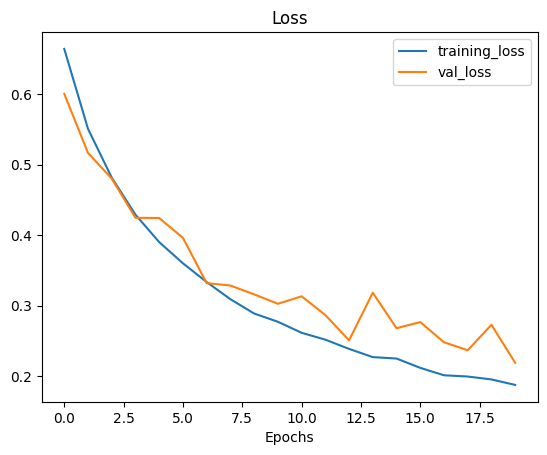

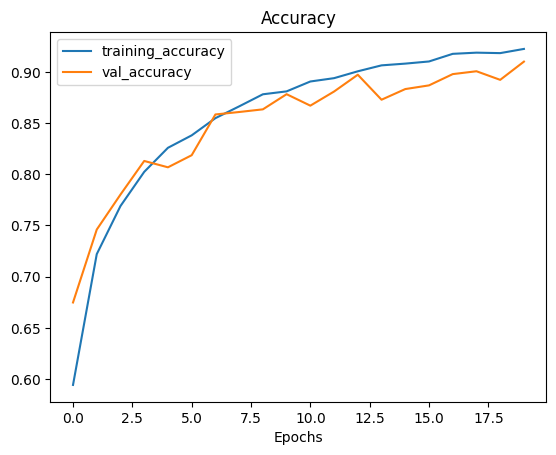

In [33]:
plot_loss_curves(history_2)

## Model 3
Let's use callbacks this time.

Callbacks are the special functions that are executed during training at given stages of the training procedure. Callbacks can help you prevent overfitting, visualize training progress, debug your code, save checkpoints, generate logs, create a TensorBoard, etc.

In [34]:
# ModelCheckPoint() saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor="val_accuracy", # save the model weights with best validation accuracy
                                   save_best_only=True, # only save the best weights
                                   save_weights_only=True, # only save model weights (not whole model)
                                   verbose=0) # don't print out whether or not model is being saved

In [35]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                              patience=3) # if val loss decreases for 3 epochs in a row, stop training

In [36]:
# Creating learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                              patience=2,
                              verbose=1, # print out when learning rate goes down
                              min_lr=1e-7)

In [37]:
# Create a model
model_3 = tf.keras.Sequential([
    Conv2D(filters=32,
                          kernel_size=3,
                          strides=1,
                          padding="valid",
                          activation="relu",
                          input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [38]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [39]:
# Fit the model
history_3 = model_3.fit(train_data,
                       epochs=50,
                       steps_per_epoch=len(train_data),
                       validation_data=valid_data,
                       validation_steps=len(valid_data),
                       callbacks=[model_checkpoint, # save only the best model during training
                                  early_stopping, # stop model after X epochs of no improvements
                                  reduce_lr]) # reduce the learning rate after X epochs of no improvements

Epoch 1/50
625/625 [==============================] - 320s 509ms/step - loss: 0.6854 - accuracy: 0.5490 - val_loss: 0.6585 - val_accuracy: 0.6374 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 313s 501ms/step - loss: 0.5928 - accuracy: 0.6884 - val_loss: 0.5420 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 338s 540ms/step - loss: 0.4963 - accuracy: 0.7578 - val_loss: 0.4882 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 323s 517ms/step - loss: 0.4422 - accuracy: 0.7914 - val_loss: 0.4343 - val_accuracy: 0.8008 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 316s 506ms/step - loss: 0.4057 - accuracy: 0.8156 - val_loss: 0.3950 - val_accuracy: 0.8296 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 321s 513ms/step - loss: 0.3762 - accuracy: 0.8288 - val_loss: 0.3880 - val_accuracy: 0.8262 - lr: 0.0010
Epoch 7/50
625/625 [==========================

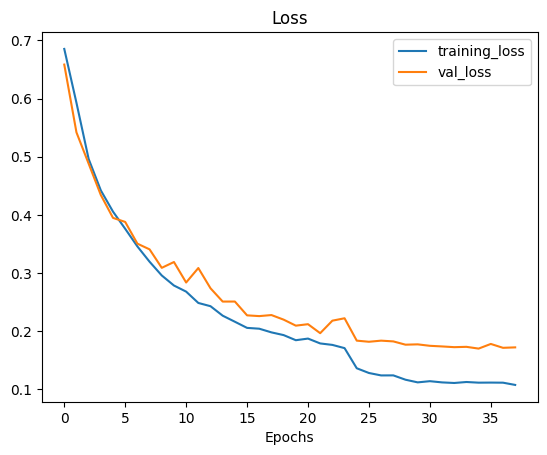

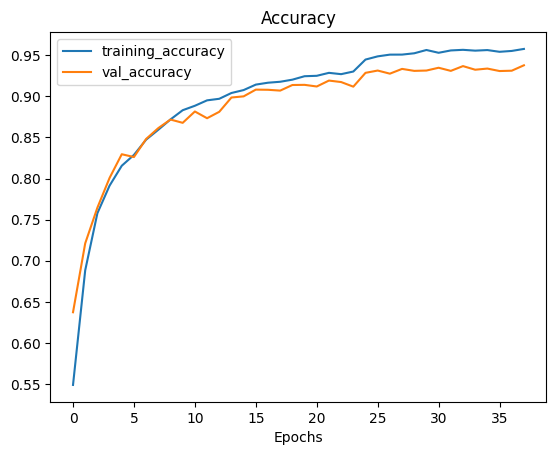

In [40]:
plot_loss_curves(history_3)

## Model 4: Pre-trained model

I am not satisfied wtih the model that I built model. Let's try a pre-trained model from [TensorFlow Hub](https://tfhub.dev/).

In [41]:
efficientnet = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2"

In [42]:
# Create model
model_4 = tf.keras.Sequential([
    hub.KerasLayer(efficientnet, input_shape=(224, 224, 3)),
    Dense(1, activation="sigmoid")
])

In [43]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [44]:
# Fit the model
history_4 = model_4.fit(train_data,
                       epochs=50,
                       steps_per_epoch=len(train_data),
                       validation_data=valid_data,
                       validation_steps=len(valid_data),
                       callbacks=[model_checkpoint, # save only the best model during training
                                  early_stopping, # stop model after X epochs of no improvements
                                  reduce_lr]) # reduce the learning rate after X epochs of no improvements

Epoch 1/50
625/625 [==============================] - 319s 498ms/step - loss: 0.0950 - accuracy: 0.9628 - val_loss: 0.0792 - val_accuracy: 0.9678 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 315s 505ms/step - loss: 0.0646 - accuracy: 0.9746 - val_loss: 0.0774 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 307s 492ms/step - loss: 0.0629 - accuracy: 0.9755 - val_loss: 0.0823 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 309s 495ms/step - loss: 0.0580 - accuracy: 0.9785 - val_loss: 0.0713 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 309s 495ms/step - loss: 0.0581 - accuracy: 0.9774 - val_loss: 0.0681 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 309s 494ms/step - loss: 0.0587 - accuracy: 0.9780 - val_loss: 0.0678 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 7/50
625/625 [==========================

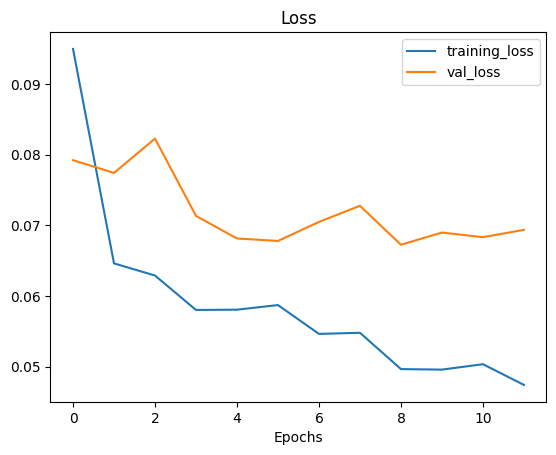

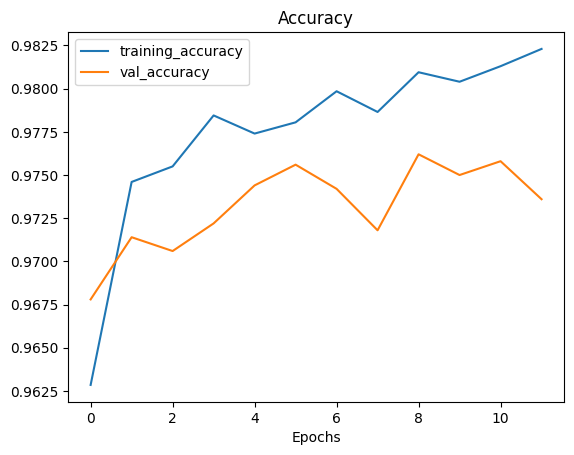

In [45]:
plot_loss_curves(history_4)

## Compare models

Let's compare our model's performance.

In [46]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Create function to unzip a zipfile into current working directory
# (since we're going to be downloading and unzipping a few files)
import zipfile


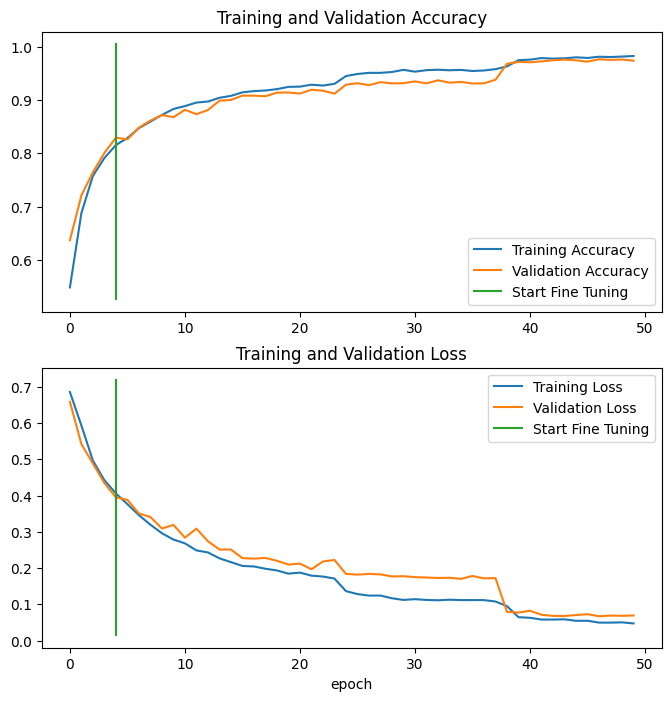

In [49]:
compare_historys(history_3, history_4)

## Prediction

In [63]:
!wget https://i.natgeofe.com/n/5f35194b-af37-4f45-a14d-60925b280986/NationalGeographic_2731043_4x3.jpg -O sample.jpg

--2023-08-31 13:33:59--  https://i.natgeofe.com/n/5f35194b-af37-4f45-a14d-60925b280986/NationalGeographic_2731043_4x3.jpg
Resolving i.natgeofe.com (i.natgeofe.com)... 23.200.156.145, 23.200.156.136, 2600:1407:3c00:2e::17c8:9cd6, ...
Connecting to i.natgeofe.com (i.natgeofe.com)|23.200.156.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374797 (366K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>] 366.01K  --.-KB/s    in 0.03s   

2023-08-31 13:33:59 (11.3 MB/s) - ‘sample.jpg’ saved [374797/374797]



In [68]:
sample = load_and_prep_image("/content/sample.jpg", scale=False)

In [74]:
model_4.predict(tf.expand_dims(sample, axis=0))

1/1 [==============================] - 0s 43ms/step


array([[1.03663664e-35]], dtype=float32)

Actually, we can add another function to show image and its predicted class. But it's enough I think.